# Apply to financial applications

Present notebook will use the present library to develop a specific case for financial application. The reference for this notebook will be:

* NEASQC deliverable: *D5.1: Review of state-of-the-art for Pricing and Computation of VaR https://www.neasqc.eu/wp-content/uploads/2021/06/NEASQC_D5.1_Review-of-state-of-the-art-for-Pricing-and-Computation-of-VaR_R2.0_Final.pdf*

The idea is given an input function $f(x)$ and a proability density $p(x)$ is compute the expected value of  $f(x)$ when x follows $p(x)$:

$$E_{x\sim p}(f)=\int_a^bp(x)f(x)dx$$

In this case we are going to use the discretized form:

$$E_{x\sim p}(f) = \sum_{x=0}^{2^n-1} p(x)f(x)dx$$

The idea is to use **Amplitude Amplification** procedure in order to compute this value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import sys
import qat.lang.AQASM as qlm
sys.path.append("../")

In [2]:
%load_ext qat.core.magic
%matplotlib inline

The qat.core.magic extension is already loaded. To reload it, use:
  %reload_ext qat.core.magic


In [3]:
global_qlmaas = True
try:
    from qlmaas.qpus import LinAlg
except (ImportError, OSError) as e:
    global_qlmaas = False
from qat.qpus import PyLinalg

In [4]:
def get_qpu(qlmass=False):
    """
    Function for selecting solver. User can chose between:
    * LinAlg: for submitting jobs to a QLM server
    * PyLinalg: for simulating jobs using myqlm lineal algebra.

    Parameters
    ----------

    qlmass : bool
        If True  try to use QLM as a Service connection to CESGA QLM
        If False PyLinalg simulator will be used

    Returns
    ----------
    
    lineal_qpu : solver for quantum jobs
    """
    if qlmass:
        if global_qlmaas:
            print('Using: LinAlg')
            linalg_qpu = LinAlg()
        else:
            raise ImportError("""Problem Using QLMaaS.Please create config file or use mylm solver""")
            
    else:
        print('Using PyLinalg')
        linalg_qpu = PyLinalg()
    return linalg_qpu

In [5]:
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg
QLMaaS = True
linalg_qpu = get_qpu(QLMaaS)

Using: LinAlg


## 1. Discretizing data

Below cell defines the functions for $p(x)$ and $f(x)$

In [6]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

First thing to do is discretizing these functions. We can use the **get_histogram** function from *utils* module

In [7]:
from libraries.utils import get_histogram

In [8]:
#number of Qbits for the circuit
n_qbits = 4

In [9]:
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

It is mandatory that $p(x)$ and $f(x)$ were properly normalized. Following conditions should be fullfilled:

* For $p(x)$ is mandatory that: $\sum_{i=0}^{2^{n}} p(i) \leq 1$
* For $f(x)$ is mandatory that: $f(i) \leq 1 \forall i$

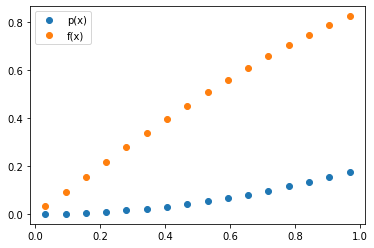

In [10]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['p(x)', 'f(x)'])

In [11]:
#Test condition in p(x)
print('p(x) condition: {}'.format(np.sum(p_X) == 1))
print('f(x) condition: {}'.format(np.max(f_X) <= 1))

p(x) condition: True
f(x) condition: True


## 2. Loading data

Second part is loading the data ($p(x)$ and $f(x)$) into the quantum state. For this we need to create following 2 loading operators:

1. $\mathcal{P}$. for loading $p(x)$
2. $\mathcal{F}$. for loading $f(x)$

So the main idea is begin with an initial $n+1$ qbits state:

$$|0\rangle_{n}\otimes|0\rangle_{1}$$

An apply the following loading operation:

$$|\Psi\rangle=\mathcal{F}\left(\mathcal{P}\otimes I\right)|0\rangle_{n}\otimes|0\rangle_{1}$$

The quantum state resulting from the loading proccess: $|\Psi\rangle$ can be expressed as a linear combination of two orthogonal states $|\Psi_{1}\rangle$ y $|\Psi_{0}\rangle$:

$$|\Psi\rangle=\sqrt{a}|\Psi_{0}\rangle+\sqrt{1-a}|\Psi_{1}\rangle$$

where:
$$|\Psi_{1}\rangle = \sum_{x=0}^{2^{n}-1}|x\rangle^{n}\otimes\frac{1}{\sqrt{1-a}}\sqrt{p(x)(1-f(x))}|1\rangle$$
$$|\Psi_{0}\rangle = \sum_{x=0}^{2^{n}-1}|x\rangle^{n}\otimes\frac{1}{\sqrt{a}}\sqrt{p(x)f(x)}|0\rangle$$
and
$$ a = \sum_{n=0}^{2^{n}-1} p(x)f(x)$$

With this operations we have loaded the desired integral into the amplitude of the state: $|\Psi_{0}\rangle$

For doing this operations **load_probability** and **load_array** functions from *data_loading* module will be used (see notebook **01_DataLoading_Module_Use.ipynb**)

In [12]:
from libraries.data_loading import load_probability, load_array

In [13]:
p_gate = load_probability(p_X)
f_gate = load_array(np.sqrt(f_X))

In [14]:
%qatdisplay p_gate --depth 0
%qatdisplay f_gate --depth 0

Now we compound the two operators $\mathcal{P}$ aqnd $\mathcal{F}$ for creating the necesary loading circuit

In [15]:
routine = qlm.QRoutine()
register = routine.new_wires(f_gate.arity)
routine.apply(p_gate, register[:p_gate.arity])
routine.apply(f_gate, register)

In [16]:
%qatdisplay routine --depth 0

We can test if the loading was properly implemented. For doing this we are going to use **get_results** from *data_extracting* module

In [17]:
from libraries.data_extracting import get_results

In [18]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

Submitted a new batch: Job6581


In [19]:
np.isclose(quantum_probabilities[0:2**p_gate.arity], p_X*f_X).all()

True

We are going to measure the complete state (**phi_state**) and the last qbit state (**InitialState**)

In [20]:
phi_state,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)#, qubits=[f_gate.arity-1])
InitialState,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu, qubits=[f_gate.arity-1])

Submitted a new batch: Job6582
Submitted a new batch: Job6583


In [21]:
np.isclose(InitialState['Probability'].iloc[0], sum(p_X*f_X))

True

## 3. Groover Operator

The main idea of **amplitude amplification** is to amplify the amplitude of the  $|\Psi_{0}\rangle$ for computing the desired integral. For this the Grover-like operator $\mathcal{G}$ will be used. In the present framework this operator can be decomposed in 2 different operators:

$$\hat{Q}=\hat{U}_{|\Psi\rangle} \hat{U}_{|\Psi_{0}\rangle}$$

Where $\hat{U}_{|\Psi\rangle}$ y $\hat{U}_{|\Psi_{0}\rangle}$ are:

$$\hat{U}_{|\Psi_{0}\rangle } = \hat{I} - 2|\Psi_{0}\rangle \langle \Psi_{0}|$$
$$\hat{U}_{|\Psi\rangle } = \hat{I} - 2|\Psi\rangle\langle \Psi|$$


In [22]:
from libraries.AE.amplitude_amplification_bis import U0, U, grover

### 3.1 $\hat{U}_{|\Psi_{0}\rangle} = \hat{I} - 2|\Psi_{0}\rangle \langle \Psi_{0}|$

For constuct this operator we need:
1. Oracle: in our case this will be the complete loading routine:

$$\mathcal{F}\left(\mathcal{P}\otimes I\right)$$

2. Target: the binnary representation of the marked state. 

3. index: the registers where the Target is.

In our case the marked state is $|\Psi_{0}\rangle$:

 $$|\Psi_{0}\rangle = \sum_{x=0}^{2^{n}-1}|x\rangle^{n}\otimes\frac{1}{\sqrt{a}}\sqrt{p(x)f(x)}|0\rangle$$

This is equivalent to a target state $|0\rangle$ on the last qbit of the quantum sistem!!


In [23]:
oracle = routine
target = [0]
index = [routine.arity-1]
u0_gate = U0(routine, target, index)

In [24]:
%qatdisplay u0_gate --depth 0

In [25]:
u0_routine = deepcopy(routine)
u0_routine.apply(u0_gate, register)

In [26]:
%qatdisplay u0_routine --depth 0

In [27]:
results_u0,_,_,_ = get_results(u0_routine, linalg_qpu=linalg_qpu)

Submitted a new batch: Job6584


In [28]:
print(np.isclose(
    results_u0[results_u0['Int_lsb'] < 2**n_qbits]['Amplitude'],
    -phi_state[phi_state['Int_lsb'] < 2**n_qbits]['Amplitude']
).all())

print(np.isclose(
    results_u0[results_u0['Int_lsb'] > 2**n_qbits]['Amplitude'],
    phi_state[phi_state['Int_lsb'] > 2**n_qbits]['Amplitude']
).all())

True
True


### 3.2 $\hat{U}_{|\Psi\rangle } = \hat{I} - 2|\Psi\rangle\langle \Psi|$

In this case we only need to provide the Oracle routine for creating the Groover diffusor

In [29]:
u_gate = U(routine)
%qatdisplay u_gate --depth 1

In [30]:
u_routine = deepcopy(routine)
u_routine.apply(u_gate, register)

In [31]:
%qatdisplay u_routine --depth 0

In [32]:
results_u,_,_,_ = get_results(u_routine, linalg_qpu=linalg_qpu)

Submitted a new batch: Job6585


In [33]:
np.isclose(
    results_u['Amplitude'], 
    -phi_state['Amplitude']
).all()

True

### 3.3 $\hat{Q}=\hat{U}_{|\Psi\rangle} \hat{U}_{|\Psi_{0}\rangle}$

For creating the desired Grover-like operator we should provide the same that for the $\hat{U}_{|\Psi_{0}\rangle}$ operator:

For constuct this operator we need:
1. Oracle: in our case this will be the complete loading routine:

$$\mathcal{F}\left(\mathcal{P}\otimes I\right)$$

2. Target: the binnary representation of the marked state. 

3. index: the registers where the Target is.

In our case the marked state is $|\Psi_{0}\rangle$:

 $$|\Psi_{0}\rangle = \sum_{x=0}^{2^{n}-1}|x\rangle^{n}\otimes\frac{1}{\sqrt{a}}\sqrt{p(x)f(x)}|0\rangle$$

This is equivalent to a target state $|0\rangle$ on the last qbit of the quantum sistem!!

In [34]:
oracle = routine
target = [0]
index = [routine.arity-1]
q_gate = grover(oracle, target, index)
%qatdisplay q_gate --depth 2

In [35]:
q_routine = deepcopy(routine)
q_routine.apply(q_gate, register)

In [36]:
%qatdisplay q_routine --depth 0

In [37]:
results_q,_,_,_ = get_results(q_routine, linalg_qpu=linalg_qpu, qubits=[u_routine.arity-1])

Submitted a new batch: Job6586


In [38]:
#First get the Amplitudes for Phi state
a0 = np.sqrt(InitialState.iloc[0]['Probability'])
a1 = np.sqrt(InitialState.iloc[1]['Probability'])

In [39]:
#Calculating Theta using the quantum state from loading data: LResults
def GetAngle(Array):
    Modulo = np.linalg.norm(Array)
    cosTheta = Array[0]/Modulo
    Theta0 = np.arccos(cosTheta)
    sinTheta = Array[1]/Modulo
    Theta1 = np.arcsin(sinTheta)
    #print(Modulo, cosTheta, sinTheta, Theta0, Theta1)
    return Theta0

#Quantum state after loading data: |Psi>
Psi_ = np.array([a0, a1])
#Angle between |Psi> and axis |Psi_0>
theta = GetAngle(Psi_)
print('theta: {}'.format(theta))
print('Psi_: {}'.format(Psi_))

theta: 0.612683425949907
Psi_: [0.81810782 0.57506486]


In [40]:
#In order to test that this theta is ok we can compute it from p(x) and f(x)
a = sum(p_X*f_X)
sqrt_a = np.sqrt(a)
theta2 = np.arccos(sqrt_a)
print('theta2: {}'.format(theta2))

print('Is theta equals to theta2: {}'.format(np.isclose(theta, theta2)))

theta2: 0.6126834259499072
Is theta equals to theta2: True


In [41]:
#Create a Rotation of 2*theta
c, s = np.cos(2*theta), np.sin(2.*theta)
#Rotation matrix
R = np.array(((c, -s), (s, c)))
#Apply Ry(2*theta) to quantum state |Psi>
RotationResults = np.dot(R, Psi_)

In [42]:
RotationResults

array([-0.26408387,  0.96449972])

In [43]:
print('Square Of Rotated Vector: {}'.format(RotationResults**2))
print('Probabilities for QPhi_State: {} '.format(list(results_q['Probability'])))
print('Square of the RotateState equal to Probabilities of Q|Phi> state : {}'.format(
    np.isclose(RotationResults**2, results_q['Probability']).all())
     )

Square Of Rotated Vector: [0.06974029 0.93025971]
Probabilities for QPhi_State: [0.06974029159846039, 0.9302597084015409] 
Square of the RotateState equal to Probabilities of Q|Phi> state : True


## 4. Phase Estimation with Quantum Fourier Transformation

Now we have the initial state after the loading procedure:

$$|\Psi\rangle=\mathcal{F}\left(\mathcal{P}\otimes I\right)|0\rangle_{n}\otimes|0\rangle_{1}$$

That can be decomposed in:

$$|\Psi\rangle=\sin{\theta}|\Psi_{1}\rangle+\cos{\theta}|\Psi_{0}\rangle$$

And the corresponding Grover-like operator $\mathcal{Q}$ based on the loading operator:

$$\mathcal{F}\left(\mathcal{P}\otimes I\right)$$

The main idea in the **amplitude amplification** is use a similar procedure like in Grover algorithm in order to increase the probability of the $|\Psi_{0}\rangle$ state. This can be in a straightoforward way by applying operator $\mathcal{Q}$ $k$ times:

$$\hat{Q}^{k}|\Psi\rangle = \sin{((2*k+1)\theta)}|\Psi_{1}\rangle+\cos{((2*k+1)\theta})|\Psi_{0}\rangle$$

The idea is apply $k$ in such a way that the probability of $|\Psi_{0}\rangle$ is maximized. For this we can equal:


$$P_{|\Psi_{1}\rangle} = \cos^{2}((2*k+1)\theta) \approx 1$$ 

So:

$$(2k+1)\theta = m\pi$$ where $m=0, 1, 2...$

We have two unknows variables: $\theta$ and $K$. If we know $\theta$ we can know how many applications of $\hat{Q}$ we need for maximazing the state we want.

The **Phase Estimation Algorithm** can be used for estimating this $\theta$:

For this we need to create n auxiliary qbits in state $|+\rangle$. Each qbit will be the controlled qbit for a controlled application of $\mathcal{Q}^{K}$ (for each controlled qbit the K will change). Finally over the auxiliary qbits we apply an inverse of the Quantum Fourier Operator ($\mathcal{QFT}$). The measurmente of this auxiliary qbits will give us an estimation of the desired $\theta$. This estimation will be more exact when more auxiliary qbits we use for the $\mathcal{QFT}$.

For this algorithm if we have $m$ auxiliary qbits and the measurment of the $\mathcal{QFT}$ is the integer $M$ then:

$$\theta = \frac{M\pi}{2^m}$$

In [44]:
from libraries.PE.some_utils import load_qn_gate

In [45]:
#Allocating Auxiliar qbits for Phase Estimation
n_aux = 7
qft_routine = deepcopy(routine)
qAux = qft_routine.new_wires(n_aux)
for i, aux in enumerate(qAux):
    qft_routine.apply(qlm.H, aux)
    step_q_gate = load_qn_gate(q_gate, 2**i)
    qft_routine.apply(step_q_gate.ctrl(), aux, register)
qft_routine.apply(qlm.qftarith.QFT(n_aux).dag(), qAux)    

In [46]:
%%time
results_q,circuit,_,_ = get_results(
    qft_routine, 
    linalg_qpu=linalg_qpu,
    qubits=range(routine.arity, routine.arity+len(qAux))
)

Submitted a new batch: Job6587
CPU times: user 138 ms, sys: 7.38 ms, total: 145 ms
Wall time: 5.88 s


In [47]:
%qatdisplay circuit --depth 0

In [48]:
results_q['Thetas'] = results_q['Int']*np.pi/(2**n_aux)
results_q.sort_values('Probability', ascending=False, inplace = True)

In [49]:
results_q.head()

,States,Int_lsb,Probability,Amplitude,Int,Thetas
76,|1001100>,76,0.497749,NaN,25,0.613592
115,|1110011>,115,0.497749,NaN,103,2.528000
11,|0001011>,11,0.000737,NaN,104,2.552544
12,|0001100>,12,0.000737,NaN,24,0.589049
51,|0110011>,51,0.000635,NaN,102,2.503457


In [50]:
len(results_q)

128

Text(0, 0.5, 'Probability')

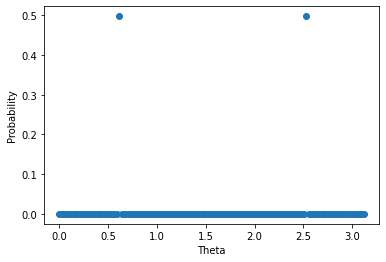

In [51]:
#Now we can plot te probability for each posible theta
%matplotlib inline
plt.plot(results_q['Thetas'], results_q['Probability'], 'o')
plt.xlabel('Theta')
plt.ylabel('Probability')

In [52]:
#We take the thetas were probability is maximum
theta_0 = results_q.sort_values('Probability', ascending =False)['Thetas'].iloc[0]
theta_1 = results_q.sort_values('Probability', ascending =False)['Thetas'].iloc[1]

print('theta_0: {}'.format(theta_0))
print('theta_1: {}'.format(theta_1))

theta_0: 0.6135923151542565
theta_1: 2.5280003384355365


In [53]:
#So we test that the 2 are the same angle with different signs
np.isclose(theta_0, np.pi -theta_1)

True

Text(0, 0.5, 'Probability')

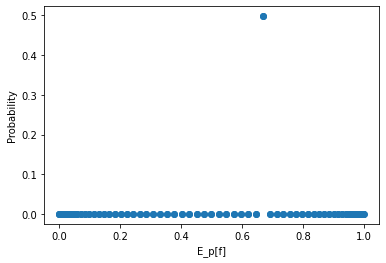

In [54]:
#Now we can plot te probability for each posible theta
%matplotlib inline
plt.plot(np.cos(results_q['Thetas'])**2, results_q['Probability'], 'o')
plt.xlabel('E_p[f]')
plt.ylabel('Probability')

In [55]:
theoric_theta = np.arccos(np.sqrt(sum(p_X*f_X)))
print('theoric_theta: {}'.format(theoric_theta))
print('theta_1: {}'.format(theta_0))
print('Theorical Integration: {}'.format(sum(p_X*f_X)))
print('Amplitude Amplification Integral: {}'.format(np.cos(theta_0)**2))

theoric_theta: 0.6126834259499072
theta_1: 0.6135923151542565
Theorical Integration: 0.6693004071633366
Amplitude Amplification Integral: 0.66844492669611


In [56]:
theoric_theta = np.arccos(np.sqrt(sum(p_X*f_X)))
print('theoric_theta: {}'.format(theoric_theta))
print('theta_1: {}'.format(theta_0))
print('Theorical Integration: {}'.format(sum(p_X*f_X)))
print('Amplitude Amplification Integral: {}'.format(np.cos(theta_0)**2))
print('Estimation Difference: {}'.format(abs(sum(p_X*f_X)-np.cos(theta_0)**2)))

theoric_theta: 0.6126834259499072
theta_1: 0.6135923151542565
Theorical Integration: 0.6693004071633366
Amplitude Amplification Integral: 0.66844492669611
Estimation Difference: 0.0008554804672266103


## 5. Maximum Likelihood Amplitude Estimation

Quantum circuit implementation of $\mathcal{QFT}$ are very complex and very long and deep so its use in actual quantum computers is noisy and not very useful.

The **Maximum Likelihood Amplitude Estimation** algorithm (**MLAE**) allows to take advantage of **amplitude amplification** without the use of the  $\mathcal{QFT}$.

For doing this  we are going to use the  **maximum_likelihood_ae** module 

In [57]:
from  libraries.AE.maximum_likelihood_ae  import MLAE

The notebook **04_MaximumLikelihood_Class** explains how this class works. In our case we need to provide:

1. Oracle
2. Target: the binnary representation of the marked state. 
3. index: the registers where the Target is.

In our case is the same that we use for generating Grover-like operator

In [58]:
oracle = deepcopy(routine)
target = [0]
index = [routine.arity-1]

In [59]:
%qatdisplay oracle

Additionally a schedule where the list of applications of Grover-like operator should be provided

In [60]:
m_k = list(range(20))
n_k = [100]*len(m_k)
schedule = [m_k,n_k]

In [61]:
mlae = MLAE(
    oracle,target = target,
    index = index,
    schedule = schedule)

In [62]:
angle = mlae.optimize()

In [63]:
print("Theta: {}".format(angle))
print("Quantum result: ",np.sin(angle)**2)

Theta: [0.95892368]
Quantum result:  [0.67006308]


In [64]:
sum(p_X*f_X)

0.6693004071633366

In [65]:
delta = 1e-5
angles = np.linspace(0+delta,np.pi/2-delta,100)

cost = np.zeros(len(angles))
for i in range(len(angles)):
    cost[i] = mlae.cost_function(angles[i])

Text(0, 0.5, '$C(\\theta)$')

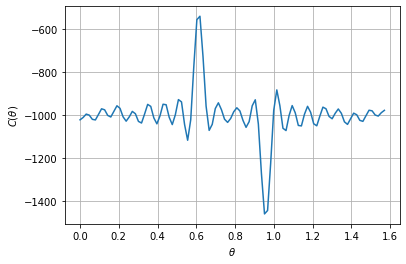

In [66]:
plt.plot(angles,cost)
#plt.axvline(theta,color = 'r')
plt.grid()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$C(\theta)$")

## 6. Iterative

Additionally we can use the *Iterative Phase Estimation* for getting the $\theta$ for this problem.
For using **IterativeQuantumPE** we need to provide:

* initial_state : in this case will be the oracle
* unitary_operator:  in this case will be the Grover-like operator build using *oracle* 
* cbits_number: number of classical bits used for phase estimation

For creating the grover operator we are going to use the *grover* function from *amplitude_amplification* module and the same *target^and *index*  then in the *maximum likelihood* class will be used:

In [67]:
from libraries.AE.amplitude_amplification_bis import grover

In [68]:
target = [0]
index = [oracle.arity-1]
q_gate = grover(oracle, target, index)

In [69]:
%qatdisplay q_gate --depth 1

In [70]:
#Load Class
from libraries.PE.iterative_quantum_pe import IterativeQuantumPE

In [71]:
n_cbits = 7
#We create a python dictionary for configuration of class
iqpe_dict = {
    'initial_state': oracle,
    'unitary_operator': q_gate,
    'qpu' : linalg_qpu,
    'cbits_number' : n_cbits,
    'shots': 100
    #'easy': True,
    #'easy': False    
}
IQPE = IterativeQuantumPE(**iqpe_dict)

In [72]:
IQPE.iqpe()

Submitted a new batch: Job6588


(array([ 0., 48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 52.]),
 array([0.61359232, 0.61359232, 0.61359232, 0.61359232, 0.61359232,
        0.61359232, 0.61359232, 0.61359232, 0.61359232, 0.61359232,
        0.61359232, 0.61359232, 0.61359232, 0.61359232, 0.61359232,
        0.61359232, 0.61359232, 0.61359232, 0.61359232, 0.61359232,
        0.61359232, 0.61359232, 0.61359232, 0.61359232, 0.61359232,
        0.61359232, 0.61359232, 0.61359232, 0.61359232, 0.61359232,
        0.61359232, 0.6135

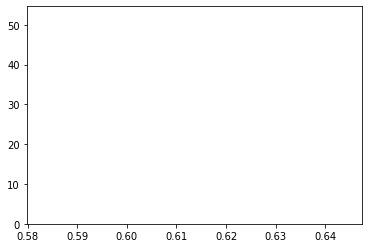

In [73]:
plt.hist(IQPE.final_results['theta_90'], bins= 100)

In [74]:
pdf = IQPE.sumary
pdf['P']=np.cos(pdf['theta_90'])**2

In [75]:
print("Classical result: ", np.sum(p_X*f_X))
print("Quantum result: ",pdf.iloc[0]['P'])

Classical result:  0.6693004071633366
Quantum result:  0.6684449266961099
